In [2]:
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/For ML #3/'

Mounted at /content/drive


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
import sklearn.metrics as metrics
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, MaxPooling1D

In [15]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [78]:
df = pd.read_csv(folder_path + 'train.csv', delimiter=',', encoding='latin-1')
df.head(3)


,id,title,author,text,label
0,0,House Dem Aide: We Didnât Even See Comeyâs...,Darrell Lucus,House Dem Aide: We Didnât Even See Comeyâs...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1


In [79]:
df.shape

(20800, 5)

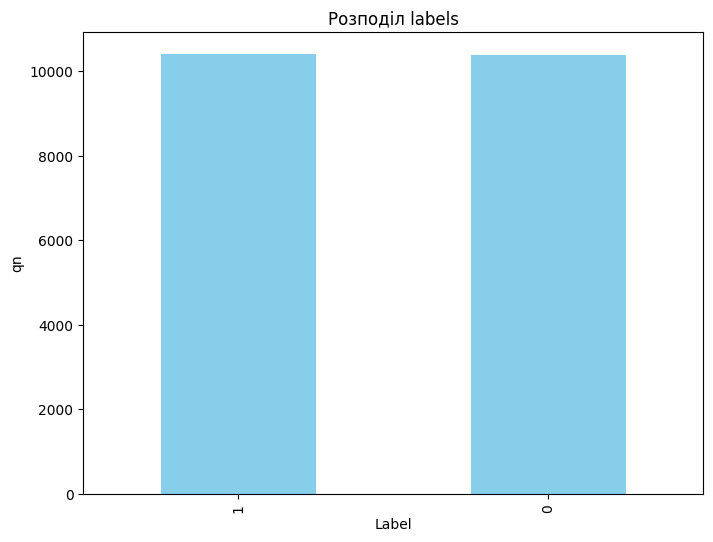

In [82]:
plt.figure(figsize=(8, 6))
df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Розподіл labels')
plt.xlabel('Label')
plt.ylabel('qn')
plt.show()

In [5]:
df = df.drop(['id','title','author'],axis=1)
df.dropna(inplace=True)
df.duplicated().sum()
df = df.drop_duplicates()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20386 entries, 0 to 20799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20386 non-null  object
 1   label   20386 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 477.8+ KB


In [7]:
df

,text,label
0,House Dem Aide: We Didnât Even See Comeyâs...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \nAn Iranian woman has been sentenced to...,1
...,...,...
20795,Rapper T. I. unloaded on black celebrities who...,0
20796,When the Green Bay Packers lost to the Washing...,0
20797,The Macyâs of today grew from the union of s...,0
20798,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [8]:
df['new_data']=df['text'].str.lower()
df['new_data']=df['new_data'].str.replace('[^A-Za-z0-9\s]','')
df['new_data']=df['new_data'].str.replace('\n','')
df['new_data']=df['new_data'].str.replace('\s+',' ')
df['new_data']

<ipython-input-8-0d44478cdaab>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['new_data']=df['new_data'].str.replace('[^A-Za-z0-9\s]','')
<ipython-input-8-0d44478cdaab>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['new_data']=df['new_data'].str.replace('\s+',' ')


0        house dem aide we didnt even see comeys letter...
1        ever get the feeling your life circles the rou...
2        why the truth might get you fired october 29 2...
3        videos 15 civilians killed in single us airstr...
4        print an iranian woman has been sentenced to s...
                               ...                        
20795    rapper t i unloaded on black celebrities who m...
20796    when the green bay packers lost to the washing...
20797    the macys of today grew from the union of seve...
20798    nato russia to hold parallel exercises in balk...
20799     david swanson is an author activist journalis...
Name: new_data, Length: 20386, dtype: object

In [16]:
stop = stopwords.words('english')
df['new_data'] = df['new_data'].apply(lambda x:" ".join([word for word in x.split() if word not in stop]))
df.head()

,text,label,new_data
0,House Dem Aide: We Didnât Even See Comeyâs...,1,house dem aide didnt even see comeys letter ja...
1,Ever get the feeling your life circles the rou...,0,ever get feeling life circles roundabout rathe...
2,"Why the Truth Might Get You Fired October 29, ...",1,truth might get fired october 29 2016 tension ...
3,Videos 15 Civilians Killed In Single US Airstr...,1,videos 15 civilians killed single us airstrike...
4,Print \nAn Iranian woman has been sentenced to...,1,print iranian woman sentenced six years prison...


In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['new_data'])
word_index= tokenizer.word_index
vocab_size = len(word_index)
vocab_size

199569

In [23]:
sequences = tokenizer.texts_to_sequences(df['new_data'])
padded_seq = pad_sequences(sequences,maxlen=600,padding='post',truncating='post')

In [24]:
embedding_index = {}
with open(folder_path + 'glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:],dtype='float32')
        embedding_index[word]=coefs


In [25]:
print(len(embedding_index))

400000


In [26]:
embedding_matrix = np.zeros((vocab_size+1,100))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [30]:
embedding_matrix[900]

array([-0.05566   ,  0.31331   ,  0.28123999,  0.25353   ,  0.37397   ,
       -0.62203002, -0.21188   , -0.53413999, -0.53184003,  0.47137001,
       -1.24609995,  0.19845   ,  0.084118  ,  0.16553   ,  0.64077997,
       -0.66562998,  0.073512  , -0.11599   ,  0.36014   , -0.23812   ,
        0.18031999, -0.15373001, -0.25075001,  0.43514001, -0.67548001,
       -0.28979999, -0.67856002, -0.85933   , -0.29589999,  0.37334001,
        0.33985001,  0.48605001, -0.62063998, -0.32657999, -0.14955001,
        0.36803001, -0.17723   , -0.10856   ,  0.025957  , -0.34208   ,
       -0.28591001, -0.35001999,  0.90057999, -0.27807   ,  0.072404  ,
       -0.033769  ,  0.45965999, -0.87867999, -0.86467999, -0.65430999,
       -0.081392  , -0.46470001,  0.41148999,  0.97918999, -0.076935  ,
       -2.40549994,  0.36406001, -0.63755   ,  1.63090003,  0.46891001,
       -0.19566999, -0.039216  , -0.66693997, -0.17605001,  1.27909994,
        0.25082001,  0.26043999, -0.26098999,  0.17227   , -0.49

In [31]:
x_train,x_test,y_train,y_test = train_test_split(padded_seq,df['label'],test_size=0.4,random_state=42,stratify=df['label'])

In [70]:
def model():
    model = Sequential()
    model.add(Embedding(vocab_size+1,100,weights=[embedding_matrix],trainable=False))
    model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(256))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [71]:
model = model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train,y_train,epochs=15,batch_size=128,validation_data=(x_test,y_test))
accuracy = history.history['val_accuracy'][-1]

Epoch 1/15
96/96 [==============================] - 9s 62ms/step - loss: 0.6523 - accuracy: 0.6004 - val_loss: 0.6959 - val_accuracy: 0.5483
Epoch 2/15
96/96 [==============================] - 5s 57ms/step - loss: 0.6585 - accuracy: 0.5886 - val_loss: 0.6169 - val_accuracy: 0.6281
Epoch 3/15
96/96 [==============================] - 5s 56ms/step - loss: 0.6565 - accuracy: 0.6000 - val_loss: 0.6289 - val_accuracy: 0.6219
Epoch 4/15
96/96 [==============================] - 6s 63ms/step - loss: 0.6327 - accuracy: 0.6150 - val_loss: 0.5937 - val_accuracy: 0.6488
Epoch 5/15
96/96 [==============================] - 6s 58ms/step - loss: 0.6304 - accuracy: 0.6438 - val_loss: 0.5518 - val_accuracy: 0.7082
Epoch 6/15
96/96 [==============================] - 6s 58ms/step - loss: 0.6124 - accuracy: 0.6530 - val_loss: 0.6019 - val_accuracy: 0.6689
Epoch 7/15
96/96 [==============================] - 6s 58ms/step - loss: 0.6172 - accuracy: 0.6367 - val_loss: 0.5569 - val_accuracy: 0.6938
Epoch 8/15
96

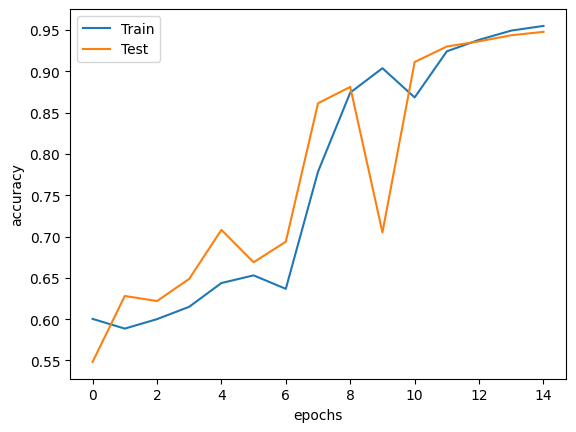

In [72]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train','Test'])
plt.show()

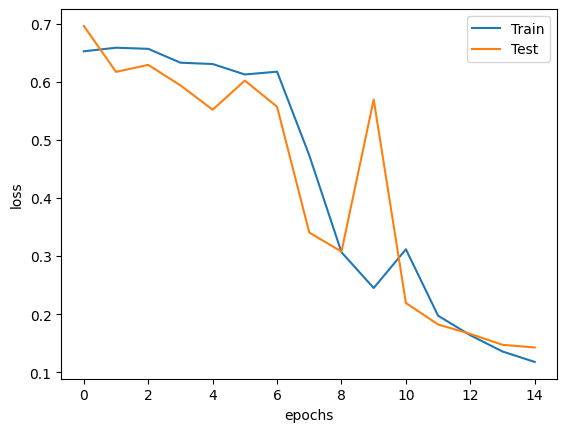

In [73]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train','Test'])
plt.show()

In [74]:
model.save("my_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
